In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -uq '/content/drive/MyDrive/Colab Notebooks/HURJC-main.zip'

In [3]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import os, warnings
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import math
import skimage.exposure
from skimage.transform import resize

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout
import glob
import seaborn as sns
import cv2

%matplotlib inline

In [4]:
labels_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/calcific_tendinopathy_ddbb (5).xlsx')

In [5]:
labels = np.array(labels_df['calcium'].tolist())
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0]


In [6]:
labels_df.head(105)

,image,calcium,pat_id,type,localization
0,001065097F_001.png,1,1065097F,2,supraespinoso
1,001065097F_002.png,1,1065097F,2,supraespinoso
2,001079917Z_001.png,1,1079917Z,1,supraespinoso e infraespinoso
3,001079917Z_002.png,1,1079917Z,1,supraespinoso e infraespinoso
4,001120686Z_001.png,1,1120686Z,2,infraespinoso
...,...,...,...,...,...
95,0080723MHD_002.png,1,80723MHD,3,supraespinoso
96,0094847_001.png,0,94847,-1,NaN
97,00RCV_001.png,1,RCV,3,supraespinoso
98,00RCV_002.png,1,RCV,3,supraespinoso


In [7]:
labels_df.describe()

,calcium,type
count,100.000000,100.000000
mean,0.780000,1.550000
std,0.416333,1.635311
min,0.000000,-1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.000000,3.000000
max,1.000000,4.000000


In [8]:
files = sorted(glob.glob('/content/HURJC-main/database/*.png'))

In [9]:
images = []
for path in files:
  img = io.imread(path)
  images.append(resize(img,(250,250,3)))

In [10]:
images = np.array(images)

In [11]:
images.shape

(100, 250, 250, 3)

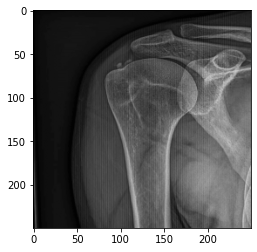

In [12]:
plt.imshow(images[0])

In [13]:
print(labels)
print(labels.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0]
(100,)


In [14]:
#indicies = np.random.permutation(100) #Aleatorización de las imágenes
#train_true_idx, test_true_idx = indicies[:90], indicies[90:] #90 imágenes de 1s en train, y 10 imágenes de 1s en test, todas ellas elegidas aleatoriamente de la primera mitad (100) de 1s

#train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100 #90 imágenes de 0s en train, y 10 imágenes de 0s en test, todas ellas elegidas aleatoriamente de la segunda mitad (100) de 0s
#train_idx, test_idx = train_true_idx, test_true_idx #Juntamos los 0s y los 1s en sus grupos correspondientes (train y test)

train_validationX, train_validationY = images[:90], labels[:90] #Primer conjunto que contiene las imágenes de train y validación
testX, testY = images[90:], labels[90:] #Segundo conjunto que contiene las imágenes de test

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)


(90, 250, 250, 3) (10, 250, 250, 3)
(90,) (10,)


In [15]:
trainX, validX, trainY, validY = train_test_split(train_validationX, train_validationY, test_size=0.1, random_state=0)

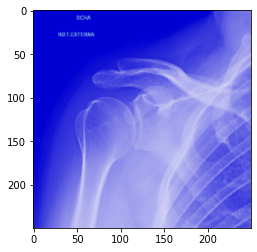

In [16]:
plt.imshow(trainX[0])

In [17]:
train_image_data = ImageDataGenerator(
    #rescale=1./255, #Normalización de las imágenes 
    zoom_range=0.05, #Zoom aleatorio sobre las imágenes
    rotation_range=180, #Rotación de las imágenes
    width_shift_range=0.05, #Fracción de anchura total
    height_shift_range=0.05, #Fracción de altura total
    horizontal_flip=True, #Voltear horizontalmente
    vertical_flip=True, #Voltear verticalmente
    fill_mode='constant', #Tipo de relleno para los inputs que están fuera de los límites
    cval=0 #Valor usado para rellenar los inputs fuera de los límites
)
validation_image_data = ImageDataGenerator(
    #rescale=1./255,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)
test_datagen = ImageDataGenerator(rescale=1./255)

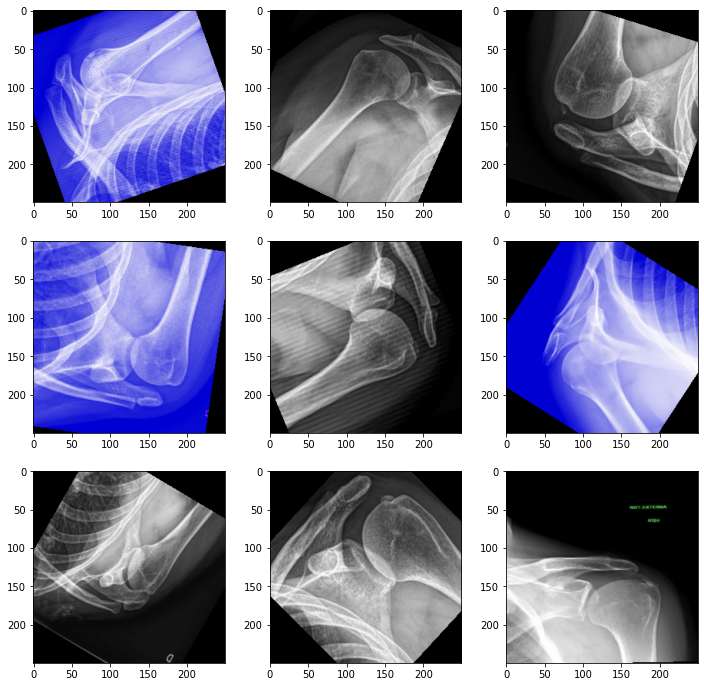

In [18]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i],cmap='gray')
    plt.show()
    break

In [19]:
from sklearn.metrics import classification_report
def check_accuracy(model, setX, actual, print_images=True): 
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)]) #Guardamos en la variable predicted la predicción (0 o 1) de nuestro modelo sobre las imágenes
    if print_images: #Generamos las imágenes con la etiqueta predicha y la verdadera
        rows = math.ceil(len(predicted)/10.) 
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)): 
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
    target_names = ['class 0', 'class 1'] 
    print(classification_report(actual, predicted, target_names=target_names))    
    confusion = confusion_matrix(actual, predicted) #Guardamos en confusion la matriz de confusión generada
    tn, fp, fn, tp = confusion.ravel() #Asignamos cada elemento de la matriz
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%") 
    return (tn, fp, fn, tp)

In [20]:
#load ChestXnet model
from tensorflow.keras.applications import DenseNet121
    
base_model = DenseNet121(weights=None,
                            include_top=False,
                            input_shape=(250,250,3), pooling="avg")

predictions = tf.keras.layers.Dense(14, activation='sigmoid', name='predictions')(base_model.output)
base_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
base_model.load_weights("/content/HURJC-main/CheXNet_Keras_0.3.0_weights.h5")
base_model.layers.pop()

In [21]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 125, 125, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [22]:
# remove last layer to create our top layers
from tensorflow.keras import Model
new_model = Model(base_model.inputs, base_model.layers[-2].output)
#freezing the weights
new_model.trainable = False

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 125, 125, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [23]:
#add two dense layers on top of the conv_base
model = models.Sequential() 
model.add(new_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu',name = 'dense_layer'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid',name = 'output_layer'))
#x = layers.Dense(64, activation='relu',name = 'dense_layer')(new_model.output)
#output = layers.Dense(1,activation = "sigmoid",name = 'output_layer')(new_model.output)

#model = Model(new_model.inputs,output)


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 1024)              7037504   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_layer (Dense)          (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 7,301,185
Trainable params: 263,169
Non-trainable params: 7,038,016
________________________________________

In [24]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [25]:
train_batch_size = 12
val_batch_size = 7

train_generator = train_image_data.flow(
    trainX,
    trainY,
    batch_size=train_batch_size)

validation_generator = validation_image_data.flow( 
    validX,
    validY,
    batch_size=val_batch_size)

In [26]:
steps_per_epoch = train_generator.n // train_batch_size
validation_steps = validation_generator.n // val_batch_size

class_weights={0:0.22, 1:0.78}

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    #callbacks=model_checkpoint_callback,
                    class_weight=class_weights,
                    epochs=100)

Epoch 1/100
6/6 [==============================] - 11s 621ms/step - loss: 0.5812 - binary_accuracy: 0.3518 - val_loss: 0.8359 - val_binary_accuracy: 0.4286
Epoch 2/100
6/6 [==============================] - 2s 166ms/step - loss: 0.4214 - binary_accuracy: 0.6793 - val_loss: 0.7602 - val_binary_accuracy: 0.5714
Epoch 3/100
6/6 [==============================] - 1s 186ms/step - loss: 0.4148 - binary_accuracy: 0.6013 - val_loss: 0.7420 - val_binary_accuracy: 0.4286
Epoch 4/100
6/6 [==============================] - 1s 183ms/step - loss: 0.4166 - binary_accuracy: 0.6508 - val_loss: 0.6958 - val_binary_accuracy: 0.4286
Epoch 5/100
6/6 [==============================] - 1s 183ms/step - loss: 0.3275 - binary_accuracy: 0.6808 - val_loss: 0.6473 - val_binary_accuracy: 0.7143
Epoch 6/100
6/6 [==============================] - 1s 186ms/step - loss: 0.2856 - binary_accuracy: 0.7950 - val_loss: 0.6928 - val_binary_accuracy: 0.5714
Epoch 7/100
6/6 [==============================] - 1s 184ms/step - lo

In [27]:
test_lost, test_acc = model.evaluate(validation_generator)
print(test_acc)

2/2 [==============================] - 1s 543ms/step - loss: 0.6898 - binary_accuracy: 0.5556
0.5555555820465088


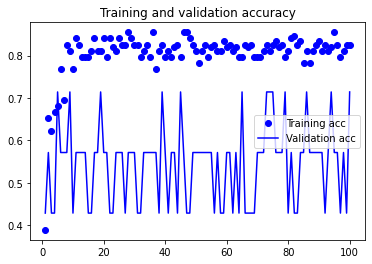

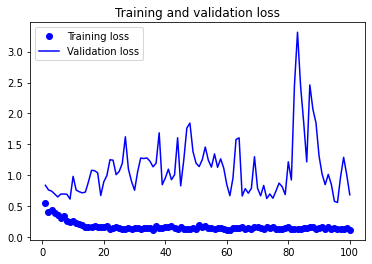

In [28]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

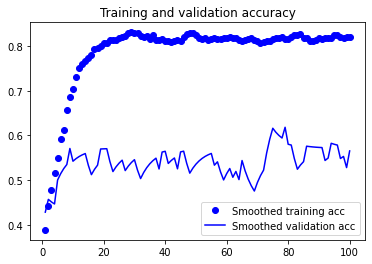

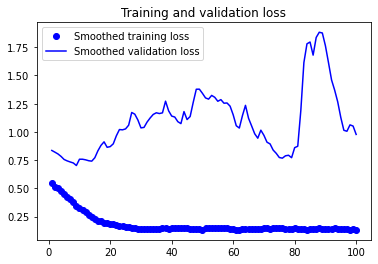

In [29]:
def smooth_curve(points, factor=0.8): 
  smoothed_points = []
  for point in points:
      if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
      else: 
          smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss') 
plt.legend()
plt.show()

              precision    recall  f1-score   support

     class 0       0.25      0.67      0.36         3
     class 1       0.50      0.14      0.22         7

    accuracy                           0.30        10
   macro avg       0.38      0.40      0.29        10
weighted avg       0.42      0.30      0.26        10

True positive: 1 , True negative: 2 , False positive: 1 , False negative: 6
Total accuracy: 30.0 %


(2, 1, 6, 1)

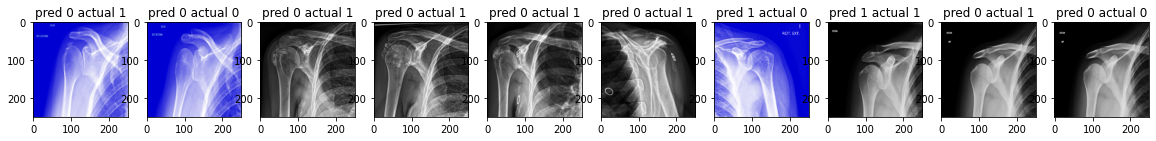

In [30]:
check_accuracy(model, testX, testY)

In [31]:
import numpy as np


def get_class_weights(total_counts, class_positive_counts, multiply):
    """
    Calculate class_weight used in training
    Arguments:
    total_counts - int
    class_positive_counts - dict of int, ex: {"Effusion": 300, "Infiltration": 500 ...}
    multiply - int, positve weighting multiply
    use_class_balancing - boolean 
    Returns:
    class_weight - dict of dict, ex: {"Effusion": { 0: 0.01, 1: 0.99 }, ... }
    """
    def get_single_class_weight(pos_counts, total_counts):
        denominator = (total_counts - pos_counts) * multiply + pos_counts
        return {
            0: pos_counts / denominator,
            1: (denominator - pos_counts) / denominator,
        }

    class_names = list(class_positive_counts.keys())
    label_counts = np.array(list(class_positive_counts.values()))
    class_weights = []
    for i, class_name in enumerate(class_names):
        class_weights.append(get_single_class_weight(label_counts[i], total_counts))

    return class_weights

In [32]:
get_class_weights(100, {"0":22, "1":78},2)

[{0: 0.12359550561797752, 1: 0.8764044943820225},
 {0: 0.639344262295082, 1: 0.36065573770491804}]

In [33]:
get_class_weights()

TypeError: ignored

https://github.com/jacobgil/keras-cam/blob/master/cam.py

In [41]:
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [61]:
from keras.models import *
from keras.callbacks import *
import keras.backend as K

import cv2
import argparse

def visualize_class_activation_map(model, img_path, output_path):
        model = model
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "output_layer")
        get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        for i, w in enumerate(class_weights[:, 1]):
                cam += w * conv_outputs[i, :, :]
        print ("predictions", predictions)
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        img = heatmap*0.5 + original_img
        cv2.imwrite(output_path, img)

In [62]:
visualize_class_activation_map(model,'/content/HURJC-main/database/001065097F_001.png','/content/HURJC-main/database/')

AttributeError: ignored